## Multi-Class Classification <span id="multi_class_classification"><span>

`Goal`: Build a NN that can perform multi-class classification.

Examples:
- Predict if a hand-drawn number on an image is between numbers [0-9].
- Predict if an image is a [horse, cow, dog, and many more classes].

This is built on the [basic_NN_binary_classification classification](./basic_NN_binary_classification.ipynb)

- A binary classifier: Predicts a value between 0 and 1, that we can round to get if model predicted 0 or 1.
- A multi-class classifier: Predicts between many, e.g, [0, 1, 2, 3 etc...] or [cat or dog or bird or dinosaur]

🛠️ **To convert a binary classifier into a multi-class classifier do following:**
1. Change the size of the models output.
    - Binary classifier outputs 1 value a number between 0 and 1.
    - But now we need the model to output the same size as what we are trying to predict for [cat or dog or bird or dinosaur] we need output size of [0.2, 0.1, 0.6, 0.1].
2. Replace the sigmoid function to Softmax function.
    - $Softmax$ Converts a vector of numbers into a probability distribution, where all the output values sum to 1.
        -  In classifying images of cats, dogs, and birds, softmax would output a probability for each class (e.g., [0.1, 0.8, 0.1], indicating an 80% probability it's a dog).
        - For this projects MNIST dataset the model needs to predict if a hand-drawn number is a value [0-9]
            - Example output would be $[0.0, 0.1, 0.2, 0.5, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0]$
                - Predicted value would be the one with the highest prediction $[0.5] which is the index $3$ meaning the model predicts the hand-drawn number to be $3$.


**Vocab:**
- Samples: One sample means having one image and its corresponding label.

⭐️ **Note:** The model is predicting on images but for the current SOTA (state of the art) applications you typically want to use CNN architectures for image detection, but even those architectures have layers that are fully connected layers which are a fundamental component of neural networks. Moreover my model can only predict one class in one image where CNN models typically predict many classes/objects in one image.

In [1]:
# Import libraries.
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get available GPU device.
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(DEVICE)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using MPS device (Apple Silicon GPU)")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU device")

Using MPS device (Apple Silicon GPU)


## Download the MNIST Dataset

- The `torch MNIST` database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .
- Drawn numbers from 0 to 9.
- Each image is `grey-scale` with 28x28 pixels. This means each pixel has a value representing its intensity (from 0 for black to 255 for white).

1. Download the MNIST dataset (~109.9 MB) from [kaggle](https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data) 
2. Rename the zip file to MNIST.zip
3. Move the zip file to ./datasets and extract.
```tree
    datasets
        └── MNIST
            ├── t10k-images-idx3-ubyte
            ├── t10k-labels-idx1-ubyte
            ├── train-images-idx3-ubyte
            └── train-labels-idx1-ubyte
```

The images and labels files are in `binary format`.

### Extract And Load The Dataset From The Binary Files

Get the images and label data for the training and test sets.

In [2]:
import os
# import utility methods
from utils.parse_binary import parse_idx_images, parse_idx_labels
import matplotlib.pyplot as plt

In [3]:
# The classes that we want the model to predict in this case hand-drawn numbers.
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Loading training images...
Train images shape: (Num samples, Height, Width) -> (60000, 28, 28)
Loading training labels...
Train labels shape: (60000,) (Num samples)

Loading test images...
Test images shape: (Num samples, Height, Width) -> (10000, 28, 28)
Loading test labels...
Test labels shape: (10000,) (Num samples)

Data loaded successfully into NumPy arrays!


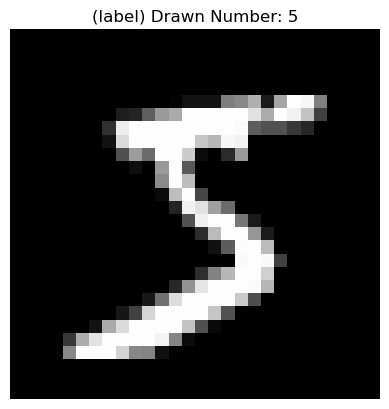

In [4]:
archive_path = './datasets/MNIST'

# File paths
train_images_path = os.path.join(archive_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels_path = os.path.join(archive_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
t10k_images_path = os.path.join(archive_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
t10k_labels_path = os.path.join(archive_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# --- Get the data into your notebook ---
print("Loading training images...")
train_images = parse_idx_images(train_images_path)
print(f"Train images shape: (Num samples, Height, Width) -> {train_images.shape}") 

print("Loading training labels...")
train_labels = parse_idx_labels(train_labels_path)
print(f"Train labels shape: {train_labels.shape} (Num samples)") 

print("\nLoading test images...")
test_images = parse_idx_images(t10k_images_path)
print(f"Test images shape: (Num samples, Height, Width) -> {test_images.shape}")

print("Loading test labels...")
test_labels = parse_idx_labels(t10k_labels_path)
print(f"Test labels shape: {test_labels.shape} (Num samples)")

print("\nData loaded successfully into NumPy arrays!")

# --- Display an image to verify ---
plt.imshow(train_images[0], cmap='gray')
plt.title(f"(label) Drawn Number: {train_labels[0]}")
plt.axis('off')
plt.show()

The `train_images` has a shape of (60000, 28, 28) -> each image is 28x28 pixels and the train set contains 60000 images

In [5]:
train_images[0].shape

(28, 28)

One single image tensor has a shape of (28, 28), which mean that image has a total node (i.e tensor values) count: $ 28 * 28 = 784 $ nodes. 

In [6]:
train_labels.shape

(60000,)

In [7]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

The `train_labels` has a shape of (60000,) a 1D tensor with 60000 values of [0-9] -> It contains the labels for the 60,000 train_images.
- train_labels = [5, 0, 4, ..., 5, 6, 8]
    - The first 5 in array means the first image has a 5 drawn on it, the 0 means the second image has a zero drawn on it and so forth.

### Pre-Process the Dataset

We need to pre-process the dataset so that we can pass it through our Neural Network that we will build later on.
- Process Labels: We need a `one-hot` tensor encoding of the label data.
    - The images in the dataset can have a label of value between `0-9`. So we make an array like so.
        - [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        - Whatever the image value is will have a value of 1 added to its index.
        - For Example: An image has a 3 drawn on it, its labeled data tensor will look like:
            - [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
            - Note: Indexing starts at zero.
        - Another example: An image has a 9 drawn on it, its labeled data tensor will look like:
            - [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

- Process Images:
    - Note that since the images are in grey-scale values they will only have 1 color channel while an RGB image will have 3 color channels. 
        - Ex:
            <img src="./showcase_images/RGB-vs-greyscale.png" width="150px">
    - The pixel values will be between 0-255 (0 for black to 255 for white). We will `normalize` the pixel values to be between 0-1 which will greatly improve how well and how fast our NN trains.
    - **Features:** Each pixel in one image is a feature, So one image has a $pixel*pixel*channel$ -> = $28*28*1=784features$.

- Classes: 
    - In this dataset we are trying to predict a hand-drawn number from [0-9] so the array that the model needs to see is [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] where 1 is the index of the hand-drawn number [9]. That array is also the **classes** of this dataset. The model will output the same tensor shape, however with float values:
        - $[0.00055817, 0.0015173, 0.030475, 0.0015173, 0.0041243, 0.011211, 0.030475, 0.082839, 0.22518, 0.6121]$
            - These values summed add up to $1$.
            - The index with the highest values is what the model predicts to be the drawn number.
                - This case $0.6121$ is the highest so 9 is the predicted hand-drawn number.

`Process the labels.`

In [8]:
# Determine the number of classes (for MNIST, it's 10)
num_classes = 10 # -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] hand draw numbers\
# For the TRAIN labels
one_hot_train_labels = np.zeros((train_labels.size, num_classes))
one_hot_train_labels[np.arange(train_labels.size), train_labels] = 1

# For the TEST labels
one_hot_test_labels = np.zeros((test_labels.size, num_classes))
one_hot_test_labels[np.arange(test_labels.size), test_labels] = 1

In [9]:
"one image label:",one_hot_train_labels[0], "All one-hot encoded labels:",one_hot_train_labels.shape

('one image label:',
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'All one-hot encoded labels:',
 (60000, 10))

`one_hot_train_labels.shape` has a shape of $(60000, 10)$, meaning that now every image now has a corresponding label that looks like $[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]$ where the $1$ index position means thats the hand-drawn number.

Test show the image and label

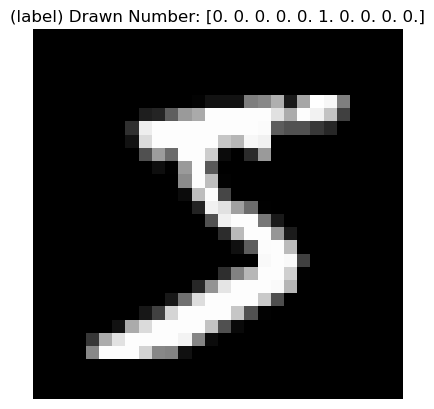

In [10]:
plt.imshow(train_images[0], cmap='gray')
plt.title(f"(label) Drawn Number: {one_hot_train_labels[0]}")
plt.axis('off')
plt.show()

`Reshape`: the tensors so we can feed it through our network.

- Image tensors needs to be $(Features, N)$, Where Features is the number of pixels per image $784$.

- Labels tensors need to be $(10, N)$, Where N is the number of samples and 10 is the number of classes.


In [11]:
"Train set:",one_hot_train_labels.shape, train_images.shape, "Test set:",one_hot_test_labels.shape, test_images.shape

('Train set:',
 (60000, 10),
 (60000, 28, 28),
 'Test set:',
 (10000, 10),
 (10000, 28, 28))

In [12]:
# Combine the 28x28 image pixels -> 784
train_images = train_images.reshape(60_000, 784)
# Transpose to get (Features, N)
train_images = train_images.T

# for the test set
test_images = test_images.reshape(10_000, 784)
test_images = test_images.T

train_images.shape, test_images.shape

((784, 60000), (784, 10000))

In [13]:
# Transpose labels to get (10, N)
one_hot_train_labels = one_hot_train_labels.T
one_hot_test_labels = one_hot_test_labels.T

one_hot_train_labels.shape, one_hot_test_labels.shape

((10, 60000), (10, 10000))

### Normalize
* Normalize the image pixel values to be between 0-1, this will greatly improve how fast our model trains and computes calculations.

In [14]:
# what the values @ pixel 400 of one image look like
train_images[:, 1][400]

np.uint8(253)

In [15]:
train_images = train_images / 255.0 # normalize -> broadcast across all images
test_images = test_images / 255.0

# What the value @ pixel 400 of one image looks like after normalizing
train_images[:, 1][400]

np.float64(0.9921568627450981)

## Build The Neural Network Algorithm

`Create the Softmax activation function.`

$$ Softmx(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j} } $$

- **Classes**:

    - The classes in our dataset are the hand-drawn numbers $[0-9]$ --> $[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]$.
    - $z_1$ is for the number $0$.
    - $z_2$ is for the number $1$.
    - ...
    - $z_9$ is for the number $8$.
    - $z_{10}$ is for the number $9$.

- **Where:**
    - $z_i$ is the logit(the output  of the previous layer in the network) for the $i^{th} class$
    - $K$ is the number of classes.
    - $e^{z_i}$ represents the exponential of the logit.
    - $\sum_{j=1}^K e^{z_j}$ is the sum of the exponentials across all classes.


In [16]:
def softmax(logits, dim):
    """
    Compute the Softmax activate function.

    Note: the size of the logits tensor is how many classes there are in the dataset.

    Arg:
        logits -- a tensor of any size.
        dim -- along which dimension should softmax be computed.

    """
    # print("TEST: There are ten classes:",logits.shape[0])

    # Find max value along the last dimension for stability
    max_logits = torch.max(logits, dim=dim, keepdim=True).values
    numerator = torch.exp(logits - max_logits)
    # Sum along the dim.
    denominator = torch.sum(numerator, dim=dim, keepdim=True)
    return numerator/denominator

In [17]:
# TEST
test = softmax(torch.tensor([1, 2, 5, 2, 3, 4, 5, 6, 7, 8]), dim=0)
test

tensor([5.5817e-04, 1.5173e-03, 3.0475e-02, 1.5173e-03, 4.1243e-03, 1.1211e-02,
        3.0475e-02, 8.2839e-02, 2.2518e-01, 6.1210e-01])

In [18]:
# output sums to 1!
torch.sum(test)

tensor(1.0000)

**⭐️ Check the binary classifier notebook for descriptions on the below functions.**
    - But we changed the model to output an array of $10$ instead of $1$ like in the binary classifier.

`Initialize weights and bias`

Parameter initialization where we initialize w *(weights)* as a vector of zeros and bias.

In [ ]:
def initialize_with_zeros(features, num_classes=10):
    """
        NOTE: Initializing all weights in a neural network to zero is generally not a good practice because it prevents the network from learning effectively. 

        This function creates a vector of zeros of shape (features, num_classes) for w (weights) and initializes b (bias) to 0.
        For MNIST, num_classes is 10 the [0-9] array.
        
        Arg:
            features -- features is the number of pixels per image.
            num_classes -- the number of classes in the dataset.
        
        Returns:
            w -- initialized tensor of shape (features, num_classes) with all zeros.
            b -- initialized scalar tensor (num_classes, 1) with all zeros.

    """
    w = torch.zeros((features, num_classes), device=DEVICE)
    b = torch.zeros((num_classes, 1), device=DEVICE)

    return w, b

In [20]:
# TEST: for 1 image
w, b = initialize_with_zeros(features=784, num_classes=10) 
w.shape, b.shape

(torch.Size([784, 10]), torch.Size([10, 1]))

`Forward & Backward propagation`

In [21]:
def propagate(w, b, X, Y):
    """
    Implement forward and back propagation.

    Arg:
        w -- weights, a torch tensor of size (features, num_classes). Where features is the number of pixels that one image has, num_classes is 10.
        b -- bias, a torch tensor of size (num_classes, 1).
        X -- data of size (features, N) where N is the number of samples.
        Y -- true "label" vector (num_classes, N) in one-hot encoded format.
        
    Return:
        grads -- dictionary containing the gradients of the cost with respect to weight w and bias b.
        (dw -- gradient of the loss with respect to w, thus the same shape as w)
        (db -- gradient of the loss with respect to b, thus the same shape as b)
        cost -- Categorical Cross-Entropy (CCE) loss.
    """
    # Get the number of samples/images
    m = X.shape[1]

    # --- 1: Forward propagate
    Z = (
        w.T @ X + b
    )  # the @ operator for matrix multiplication or dot-product, the .T is to transpose that tensor.
    A = softmax(Z, dim=0)  # Apply softmax along the class dimension (dim=0)

    # --- 2: Calculate Cost (Categorical Cross-Entropy Loss) ---
    epsilon = 1e-9  # For numerical stability to prevent log(0)
    cost = -1 / m * torch.sum(Y * torch.log(A + epsilon))

    # --- 3: Backward propagate ---
    # Gradient of the loss with respect to Z (logits)
    dZ = A - Y  # This is the common gradient for softmax + CCE
    # Gradient of the loss with respect to w
    dw = 1 / m * (X @ dZ.T)
    # Gradient of the loss with respect to b
    db = 1 / m * torch.sum(dZ, dim=1, keepdim=True)

    grads = {"dw": dw, "db": db}
    return grads, cost

In [22]:
# TEST with one image:
# [:, 0] gets the first image from the train_images
one_image = train_images[:, 0].reshape(784, 1) # shape: (784,) -> reshape to (784, 1)
one_label = one_hot_train_labels[:, 0].reshape(10, 1) # shape: (10,) -> reshape to (10, 1)
# move to torch and GPU device 
one_image = torch.from_numpy(one_image).float().to(DEVICE)
one_label = torch.from_numpy(one_label).float().to(DEVICE)

w, b  = initialize_with_zeros(features=784,num_classes=10)
propagate(w, b, X=one_image, Y=one_label)

({'dw': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0'),
  'db': tensor([[ 0.1000],
          [ 0.1000],
          [ 0.1000],
          [ 0.1000],
          [ 0.1000],
          [-0.9000],
          [ 0.1000],
          [ 0.1000],
          [ 0.1000],
          [ 0.1000]], device='mps:0')},
 tensor(2.3026, device='mps:0'))

`Optimizer`

In [23]:
import copy

def optimize(w, b, X, Y, Epoch=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm.

    Arg:

        w -- weights, a torch tensor of size (features, num_classes). Where features is the number of pixels that one image has, num_classes is 10.
        b -- bias, a torch tensor of size (num_classes, 1).
        X -- data of size (features, N) where N is the number of samples.
        Y -- true "label" vector (num_classes, N) in one-hot encoded format.

        Epoch  -- hyperparameter. The number of times that the model sees the train dataset, e.g., Epoch=5 means the models loops through the train dataset 5 times.
        learning_rate -- a hyperparameter that controls the step size during the optimization process, determining how much the model's parameters are adjusted in response to the estimated error at each iteration.
        print_cost -- True to print the loss every 100 steps

    Returns:
        params -- dictionary containing the weights w and bias b
        grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
        costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve
    """

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(Epoch):
        # --- Forward & Backward propagation.
        #    cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads.
        dw = grads["dw"]
        db = grads["db"]
        
        # --- Gradient descent:
        #   Optimizer is Stochastic Gradient Descent (SGD).
        #   Update the weight and bias to make the model predict closer to the true target.
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            
            if print_cost and i % 100 == 0:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

`Predict`

In [24]:
def predict(w, b, X):
    '''
    Predict the hand-drawn number using the learned logistic regression parameters (w, b).
    
    Arg:
        w -- weights, a torch.Tensor of size (features, num_classes), where features is the number of pixels per image and num_classes = an array size of 10 the hand-drawn numbers.
        b -- bias, a torch tensor of size (num_classes, 1).
        X -- data, a torch tensor of size (features, N), where N is the number of samples.

    Returns:
        Y_prediction_final -- a torch tensor of one-hot encoded predictions, shape: (num_classes, N).
    '''

    num_samples = X.shape[1]
    num_classes = w.shape[1] # Should be 10 for MNIST

    w = w.reshape(X.shape[0], 10)
    
    # --- Predict ---
    # Compute raw scores (logits) ---
    Z = w.T @ X + b

    # Apply Softmax to get probabilities
    A = softmax(Z, dim=0)

    # --- Re-fine predictions ---

    # Get the predicted class index for each sample
    # torch.argmax(A, dim=0) finds the index of the maximum probability along the class dimension (dim=0).
        # ex: argmax([0, 5, 3]) returns -> index: 1 which is =5
    predicted_class_indices = torch.argmax(A, dim=0) # Shape: (num_samples,)

     # Convert predicted class indices to one-hot encoded predictions manually
    # Create an empty tensor for one-hot predictions
    Y_prediction_one_hot = torch.zeros((num_samples, num_classes), device=DEVICE)

    # Fill in the 1s at the predicted class indices
    Y_prediction_one_hot[torch.arange(num_samples), predicted_class_indices] = 1.0

    # Transpose the result to get the desired shape (num_classes, num_samples)
    Y_prediction_final = Y_prediction_one_hot.T

    return Y_prediction_final

In [25]:
# TEST predict() with one image:
# Note the parameters w, b haven't been trained so the prediction will be terrible.
one_image = train_images[:, 0].reshape(784, 1) # shape: (784,) -> reshape to (784, 1)
# move to torch and GPU device 
one_image = torch.from_numpy(one_image).float().to(DEVICE)
w, b  = initialize_with_zeros(features=784,num_classes=10)
predict(w, b, X=torch.from_numpy(train_images).float().to(DEVICE))

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')

`Create Model to put everything together`

In [26]:
def model(X_train, Y_train, X_test, Y_test, Epoch=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the functions implemented above.
    
    num_classes for MNIST is 10.

    Arg:
        X_train -- training set represented by a tensor of shape (features, train_samples), Where features is the number of pixels per image
        Y_train -- training labels represented by a tensor of shape (num_classes, train_samples)
        
        X_test -- test set represented by a tensor of shape (features, test_samples)
        Y_test -- test labels represented by a tensor of shape (num_classes, test_samples)

        Epoch  -- hyperparameter. The number of times that the model sees the train dataset, e.g., Epoch=5 means the models loops through the train dataset 5 times.
        learning_rate -- a hyperparameter that controls the step size during the optimization process, determining how much the model's parameters are adjusted in response to the estimated error at each iteration.
        print_cost -- Set to true to print the cost every 100 iterations
    
    returns:
        d -- dictionary containing information about the model
    """

    # --- Move data to torch from Numpy to utilize GPU if available.
    # train set
    X_train = torch.from_numpy(X_train).float().to(DEVICE) # I added .float() because MPS framework doesn't support float64. So used float32 instead.
    Y_train = torch.from_numpy(Y_train).float().to(DEVICE) 

    # test set
    X_test = torch.from_numpy(X_test).float().to(DEVICE) 
    Y_test = torch.from_numpy(Y_test).float().to(DEVICE)

    # Initialize parameters w and b with zeros.
    w, b = initialize_with_zeros(X_train.shape[0])

    # --- 1:  Forward & Backward propagate
    params, grads, costs = optimize(w, b, X_train, Y_train, Epoch, learning_rate, print_cost)
    
    # Retrieve the learning parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
    
    # --- 2: predict test/train set examples
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    # Print train/test Errors
    if print_cost:
        print("\nPredict:")
        # For training accuracy
        #   Get the predicted index value
        train_pred_indices = torch.argmax(Y_prediction_train, dim=0)
        #   Get the target/label index value
        train_true_indices = torch.argmax(Y_train, dim=0)
        #   See how many time the predicted matches the target.
        train_acc = torch.mean((train_pred_indices == train_true_indices).float()) * 100
        print(f"train accuracy: {train_acc:.2f} %")

        # For test accuracy
        test_pred_indices = torch.argmax(Y_prediction_test, dim=0)
        test_true_indices = torch.argmax(Y_test, dim=0)
        test_acc = torch.mean((test_pred_indices == test_true_indices).float()) * 100
        print(f"test accuracy: {test_acc:.2f} %")

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "Epoch": Epoch}
    
    return d

`Train the model`

In [27]:
trained_MNIST = model(train_images, one_hot_train_labels, test_images, one_hot_test_labels, Epoch=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 2.302585
Cost after iteration 100: 1.858551
Cost after iteration 200: 1.554516
Cost after iteration 300: 1.343795
Cost after iteration 400: 1.193889
Cost after iteration 500: 1.083495
Cost after iteration 600: 0.999388
Cost after iteration 700: 0.933350
Cost after iteration 800: 0.880150
Cost after iteration 900: 0.836356
Cost after iteration 1000: 0.799640
Cost after iteration 1100: 0.768380
Cost after iteration 1200: 0.741411
Cost after iteration 1300: 0.717878
Cost after iteration 1400: 0.697141
Cost after iteration 1500: 0.678710
Cost after iteration 1600: 0.662204
Cost after iteration 1700: 0.647323
Cost after iteration 1800: 0.633826
Cost after iteration 1900: 0.621520

Predict:
train accuracy: 86.13 %
test accuracy: 87.08 %


`Check prediction`

Hand-drawn number = 3 -> model predicted that it is the number: '3'


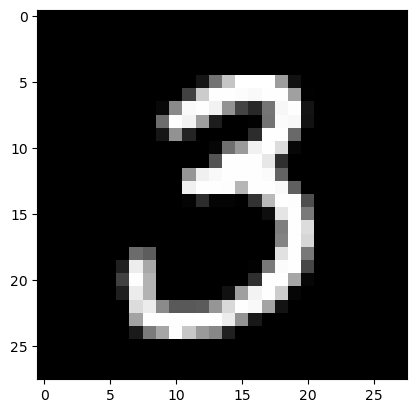

In [28]:
# Grab one of the test images that the model predicted on
img_index = 90
print( f"Hand-drawn number = {classes[np.argmax(one_hot_test_labels[: , img_index])]} -> model predicted that it is the number: '{classes[torch.argmax(trained_MNIST['Y_prediction_test'][:, img_index])]}'")
plt.imshow(test_images[:, img_index].reshape((28, 28)), cmap='gray')
plt.show()

`Plot` the cost

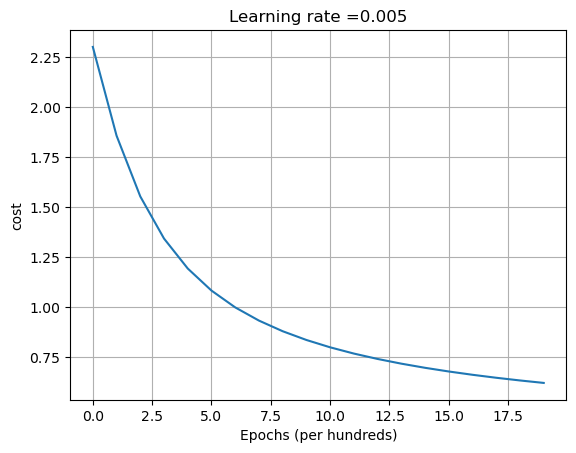

In [ ]:
# Plot learning curve (with costs)
costs = torch.squeeze(torch.tensor(trained_MNIST['costs']))
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('Epochs (per hundreds)')
plt.title("Learning rate =" + str(trained_MNIST["learning_rate"]))
plt.grid(True)
plt.show()